In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import pylab as plt
%matplotlib inline
import torchvision.utils as vutils
import glob
import os
import re
import requests

In [2]:
import sys
sys.path.append('../')
import models
import models.mnist
from data import get_loaders
from main import DictWrapper

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
# using event multiplexer from tensorboard
import tensorboard_extract as tb_extract
import tensorflow as tf
from tensorboard.backend.event_processing import plugin_event_multiplexer as event_multiplexer


class TBMultiplexer:
    def __init__(self, logdir):
        self.logdir = logdir
        SIZE_GUIDANCE = {'scalars': 1000}
        self.multiplexer = event_multiplexer.EventMultiplexer(tensor_size_guidance=SIZE_GUIDANCE)
        self.multiplexer.AddRunsFromDirectory(logdir)
    
    def add_runs(self, patterns):
        run_names = get_run_names(self.logdir, patterns)
        for run_name in run_names:
            self.multiplexer.AddRun(run_name)
        
    def reload(self):
        self.multiplexer.Reload()
    
    def get_data(self, logdir, run_names, tag_names):
        data = []
        for run_name in run_names:
            d = {}
            for tag_name in tag_names:
                js = tb_extract.extract_scalars(self.multiplexer, run_name[len(self.logdir):], tag_name)
                d[tag_name] = np.array([[x[j] for x in js] for j in range(1,3)])
            data += [d]
        return data

In [5]:
def get_run_names(logdir, patterns):
    run_names = []
    for pattern in patterns:
        for root, subdirs, files in os.walk(logdir, followlinks=True):
            if re.match(pattern, root):
                run_names += [root]
    # print(run_names)
    return run_names    

In [6]:
def get_data(logdir, run_names, tag_names):
    data = []
    for run_name in run_names:
        d = {}
        for tag_name in tag_names:
            resp = requests.get('http://localhost:6007/data/plugin/scalars/scalars?',
                                params={'run': run_name[len(logdir):], 'tag': tag_name})
            # print(resp.url)
            js = resp.json()
            d[tag_name] = np.array([[x[j] for x in js] for j in range(1,3)])
        data += [d]
    return data

In [7]:
def get_data_pth(logdir, run_names, tag_names):
    data = []
    for run_name in run_names:
        d = {}
        logdata = torch.load(run_name+'/log.pth.tar')
        for tag_name in tag_names:
            if tag_name not in logdata:
                continue
            js = logdata[tag_name]
            if '_h' in tag_name:
                d[tag_name] = js[-1][2]
            else:
                d[tag_name] = np.array([[x[j] for x in js] for j in range(1, 3)])
        data += [d]
    return data

In [8]:
from scipy.interpolate import spline
def plot_smooth(x, y, *args, **kwargs):
    x_smooth = np.linspace(x.min(), x.max(), 100)
    y_smooth = spline(x, y, x_smooth)
    # x_smooth = x
    # y_smooth = y
    plt.plot(x_smooth, y_smooth, *args, **kwargs)

In [77]:
def plot_tag(data, run_names, tag_name, lg_tags, ylim=None, color0=0):
    xlabel = {'Tacc_Nex': '# Examples Processed', 'Tacc': 'Training Iteration',
              'Vacc_Nex': '# Examples Processed', 'Vacc': 'Training Iteration',
              'touch_p_Nex': '# Examples Processed', 'touch_p': 'Training Iteration',
              'visits_h': '# Visits', 'loss': 'Training Iteration'}
    ylabel = {'Tacc_Nex': 'Training Accuracy (%)', 'Tacc': 'Training Accuracy (%)',
              'Vacc_Nex': 'Test Accuracy (%)', 'Vacc': 'Test Accuracy (%)',
              'touch_p_Nex': '# Examples Visited', 'touch_p': '# Examples Visited',
              'visits_h': '# Examples Visited', 'loss': 'Loss'}
    titles = {'Tacc_Nex': 'Training Accuracy', 'Tacc': 'Training Accuracy',
              'Vacc_Nex': 'Test Accuracy', 'Vacc': 'Test Accuracy',
              'touch_p_Nex': 'Percentage of Examples Visited per Round',
              'touch_p': 'Percentage of Examples Visited per Round',
              'visits_h': 'Histogram of Visits', 'loss': 'Loss'}
    
    if not isinstance(data, list):
        data = [data]
        run_names = [run_names]

    color = ['blue', 'orangered', 'limegreen', 'darkkhaki', 'cyan', 'black']
    plt.rcParams.update({'font.size': 12})
    plt.grid(linewidth=1)
    legends = []
    for i in range(len(data)):
        lg = ""
        for lgt in lg_tags:
            mg = re.search(lgt+".*?($|,)", run_names[i])
            if mg:
                lg += mg.group(0)
        legends += [lg]
        if isinstance(data[i][tag_name], tuple):
            # plt.hist(data[i][tag_name][0], data[i][tag_name][1], color=color[i])
            edges = data[i][tag_name][1]
            frq = data[i][tag_name][0]
            plt.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge", color=color[color0+i])
        else:
            plot_f(data[i][tag_name][0], data[i][tag_name][1], '-', color=color[color0+i], linewidth=2)
    plt.title(titles[tag_name])
    if ylim is not None:
        plt.ylim(ylim)
    # plt.xlim([0, 25000])
    plt.legend(legends)
    plt.xlabel(xlabel[tag_name])
    plt.ylabel(ylabel[tag_name])

In [437]:
def plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name,
                      lg_tags, ylim):
    run_names = get_run_names(logdir, patterns)
    data = get_data_f(logdir, run_names, tag_names)
    if len(data) == 0:
        return data, run_names
    # plt.figure(figsize=(26,14))
    # nruns = len(run_names)
    # nruns = 2
    nruns = len(data)
    dm = []
    for i in range(len(data)):
        dm += [True]
        for tg in tag_names:
            if tg not in data[i]:
                dm[i] = False
                nruns -= 1
                break
    height = 1
    for tg in tag_names:
        if 'visits' in tg:
            height += (nruns+1)//2
    fig=plt.figure(figsize=(14,4*height))
    fig.subplots(height, 2)
    plt.tight_layout(pad=1., w_pad=3., h_pad=3.0)
    fi = 1
    for i in range(len(tag_names)):
        plt.subplot(height, 2, fi)
        if 'visits' in tag_names[i]:
            for j in range(len(data)):
                if not dm[j]:
                    continue
                plt.subplot(height, 2, fi)
                plot_tag(data[j], run_names[j], tag_names[i], lg_tags, color0=j)
                fi += 1
        else:
            plot_tag(data, run_names, tag_names[i], lg_tags, ylim)
            fi += 1
    plt.savefig(fig_name, dpi=100, bbox_inches='tight')
    return data, run_names

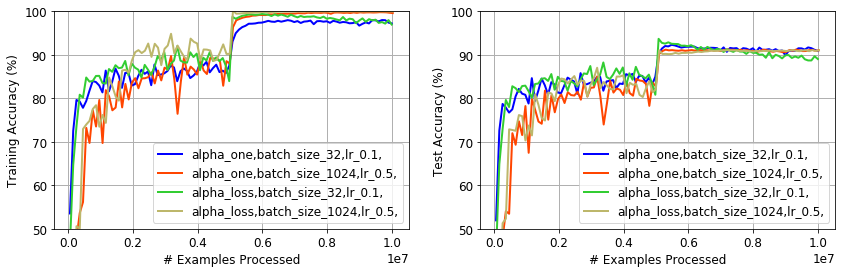

In [85]:
get_data_f = get_data
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_bs.*/.*(batch_size_32.*lr_0.1|1024.*lr_0.5).*']
tag_names = ['Tacc_Nex', 'Vacc_Nex']
fig_name = 'figs_new/cifar10_bs_1024_vs_32_nex.png'
lg_tags = ['alpha_', 'batch_size_', 'lr_0']ids
run_names = get_run_names(logdir, patterns)
data = get_data_f(logdir, run_names, tag_names)
plt.figure(figsize=(14,4))
for i in range(len(tag_names)):
    plt.subplot(1, 2, i+1)
    plot_tag(data, run_names, tag_names[i], lg_tags, [50, 100])
plt.savefig(fig_name, dpi=100, bbox_inches='tight')

In [ ]:
mx = tbmultiplexer.multiplexer
tbmultiplexer = TBMultiplexer(logdir)
tbmultiplexer.multiplexer = mx

In [ ]:
logdir = '/u/faghri/dmom/code/runs/'
tbmultiplexer = TBMultiplexer(logdir)

In [ ]:
tbmultiplexer.reload()

In [ ]:
data = tbmultiplexer.get_data(patterns, tag_names)

# Linrank + dmom fix
* mnist good, but can't get speedups with /2 epochs, can do 2/3
* baseline fixed, histogram of visits converges to normal around # epochs
* histogram of visits has 2 peaks one close to 0 and one close to the right tail which are support vectors


* cifar10, svhn overfits (other papers do as well but it goes away if you do 3rd lr decay)
* it still converges faster in training time, so maybe some regularization
* we don't get clear cut for support vectors

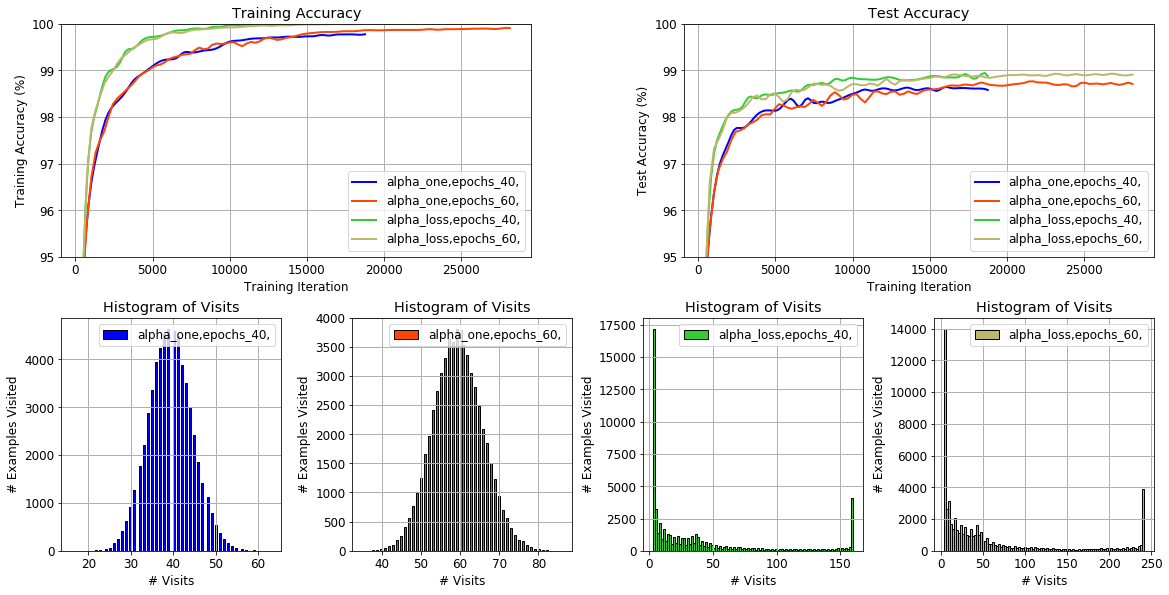

In [343]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*mnist_linrank/.*alpha_(one|loss).*']
tag_names = ['Tacc', 'Vacc', 'visits_h']
fig_name = 'figs_new/mnist_linrank_epochs_40_vs_60.png'
lg_tags = ['alpha_', 'epochs_']
run_names = get_run_names(logdir, patterns)
data = get_data_f(logdir, run_names, tag_names)
fig=plt.figure(figsize=(16,8))
# plt.figure(figsize=(26,14))
nruns = len(run_names)
fig.subplots(2, nruns)
plt.tight_layout(pad=1., w_pad=3., h_pad=3.0)
plt.subplot(2, 2, 1)
plot_tag(data, run_names, tag_names[0], lg_tags, [95, 100])
plt.subplot(2, 2, 2)
plot_tag(data, run_names, tag_names[1], lg_tags, [95, 100])
for i in range(nruns):
    plt.subplot(2, nruns, nruns+1+i)
    plot_tag(data[i], run_names[i], tag_names[2], lg_tags, color0=i)
plt.savefig(fig_name, dpi=100, bbox_inches='tight')

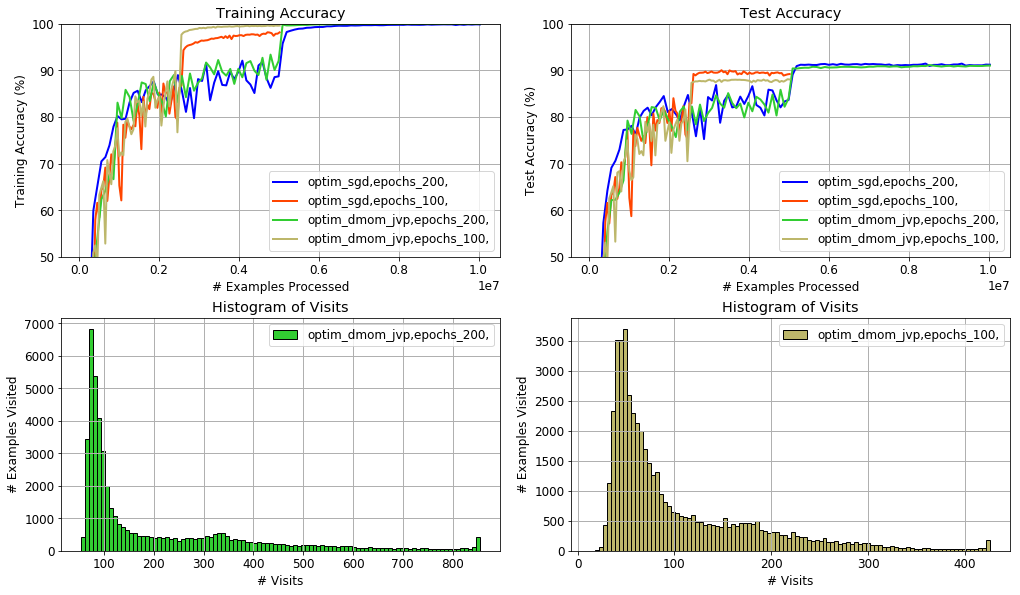

In [322]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank/.*batch_size_1024*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_bs_1024.png'
lg_tags = ['optim_', 'epochs_']
run_names = get_run_names(logdir, patterns)
data = get_data_f(logdir, run_names, tag_names)
fig=plt.figure(figsize=(14,8))
# plt.figure(figsize=(26,14))
# nruns = len(run_names)
nruns = 2
fig.subplots(2, nruns)
plt.tight_layout(pad=1., w_pad=3., h_pad=3.0)
plt.subplot(2, 2, 1)
plot_tag(data, run_names, tag_names[0], lg_tags, [50, 100])
plt.subplot(2, 2, 2)
plot_tag(data, run_names, tag_names[1], lg_tags, [50, 100])
plt.subplot(2, 2, 3)
plot_tag(data[2], run_names[2], tag_names[2], lg_tags, color0=2)
plt.subplot(2, 2, 4)
plot_tag(data[3], run_names[3], tag_names[2], lg_tags, color0=3)
plt.savefig(fig_name, dpi=100, bbox_inches='tight')

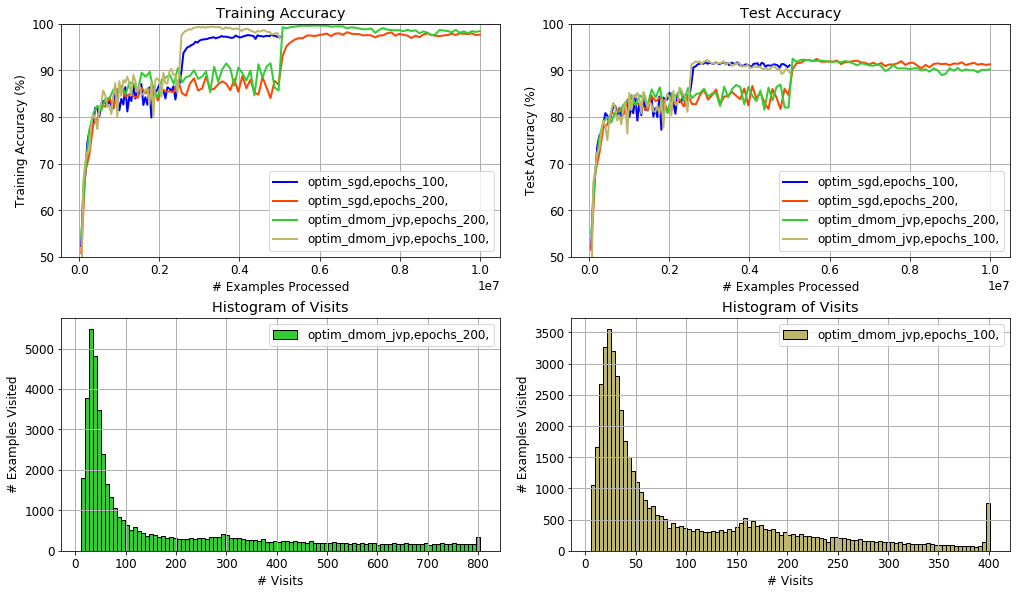

In [11]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank/.*batch_size_32.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_bs_32.png'
lg_tags = ['optim_', 'epochs_']
run_names = get_run_names(logdir, patterns)
data = get_data_f(logdir, run_names, tag_names)
fig=plt.figure(figsize=(14,8))
# plt.figure(figsize=(26,14))
# nruns = len(run_names)
nruns = 2
fig.subplots(2, nruns)
plt.tight_layout(pad=1., w_pad=3., h_pad=3.0)
plt.subplot(2, 2, 1)
plot_tag(data, run_names, tag_names[0], lg_tags, [50, 100])
plt.subplot(2, 2, 2)
plot_tag(data, run_names, tag_names[1], lg_tags, [50, 100])
plt.subplot(2, 2, 3)
plot_tag(data[2], run_names[2], tag_names[2], lg_tags, color0=2)
plt.subplot(2, 2, 4)
plot_tag(data[3], run_names[3], tag_names[2], lg_tags, color0=3)
plt.savefig(fig_name, dpi=100, bbox_inches='tight')

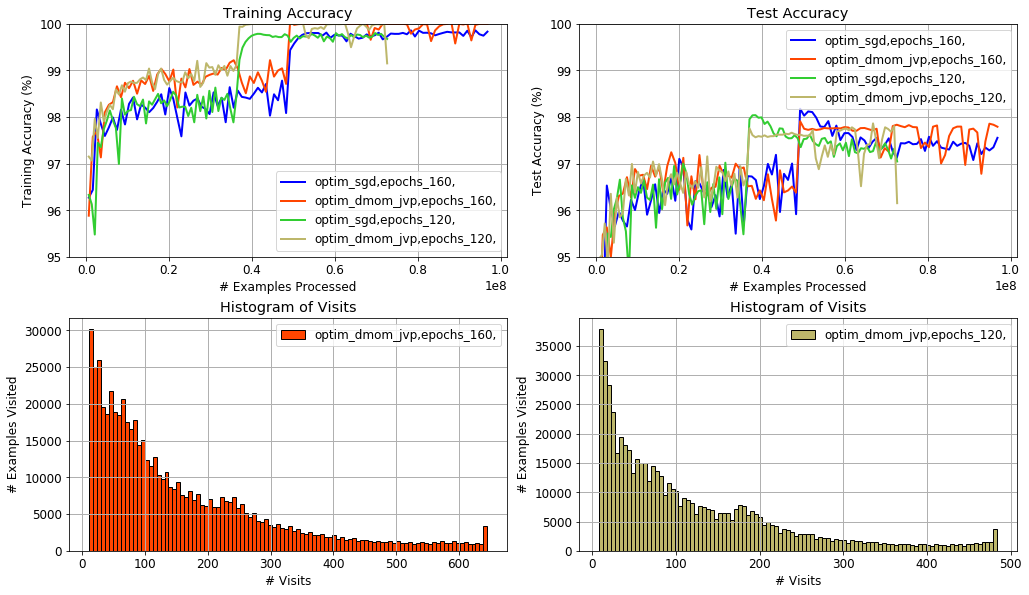

In [336]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank/.*batch_size_1024*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_bs_1024.png'
lg_tags = ['optim_', 'epochs_']
run_names = get_run_names(logdir, patterns)
data = get_data_f(logdir, run_names, tag_names)
fig=plt.figure(figsize=(14,8))
# plt.figure(figsize=(26,14))
# nruns = len(run_names)
nruns = 2
fig.subplots(2, nruns)
plt.tight_layout(pad=1., w_pad=3., h_pad=3.0)
plt.subplot(2, 2, 1)
plot_tag(data, run_names, tag_names[0], lg_tags, [95, 100])
plt.subplot(2, 2, 2)
plot_tag(data, run_names, tag_names[1], lg_tags, [95, 100])
plt.subplot(2, 2, 3)
plot_tag(data[1], run_names[1], tag_names[2], lg_tags, color0=1)
plt.subplot(2, 2, 4)
plot_tag(data[3], run_names[3], tag_names[2], lg_tags, color0=3)
plt.savefig(fig_name, dpi=100, bbox_inches='tight')

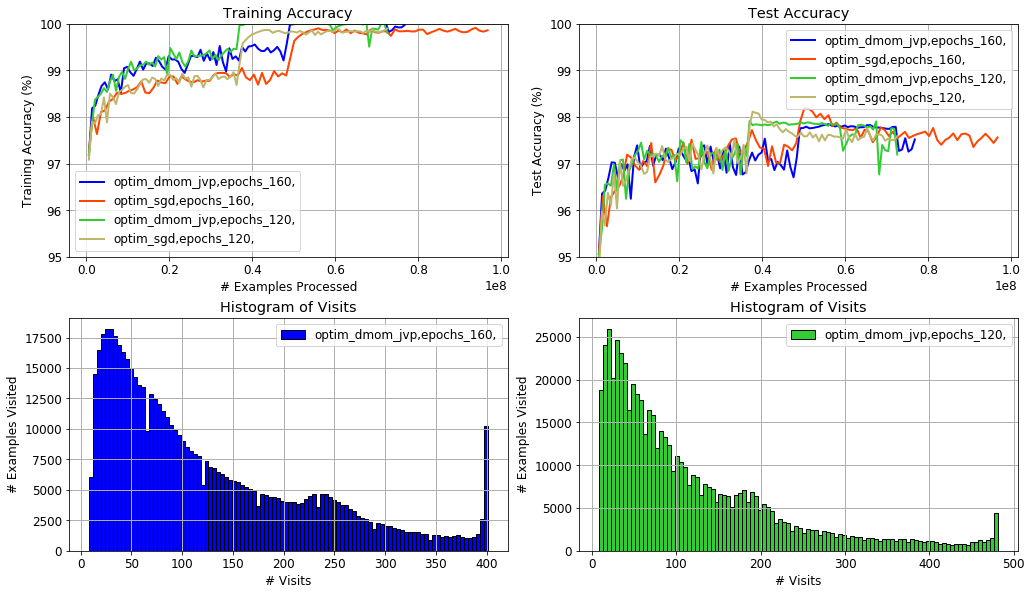

In [14]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank/.*batch_size_128*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_bs_128.png'
lg_tags = ['optim_', 'epochs_']
run_names = get_run_names(logdir, patterns)
data = get_data_f(logdir, run_names, tag_names)
fig=plt.figure(figsize=(14,8))
# plt.figure(figsize=(26,14))
# nruns = len(run_names)
nruns = 2
fig.subplots(2, nruns)
plt.tight_layout(pad=1., w_pad=3., h_pad=3.0)
plt.subplot(2, 2, 1)
plot_tag(data, run_names, tag_names[0], lg_tags, [95, 100])
plt.subplot(2, 2, 2)
plot_tag(data, run_names, tag_names[1], lg_tags, [95, 100])
i=0
plt.subplot(2, 2, 3)
plot_tag(data[i], run_names[i], tag_names[2], lg_tags, color0=i)
i=2
plt.subplot(2, 2, 4)
plot_tag(data[i], run_names[i], tag_names[2], lg_tags, color0=i)
plt.savefig(fig_name, dpi=100, bbox_inches='tight')

# Exp LR

* 3 exp lr decay drops added, got rid of overfitting

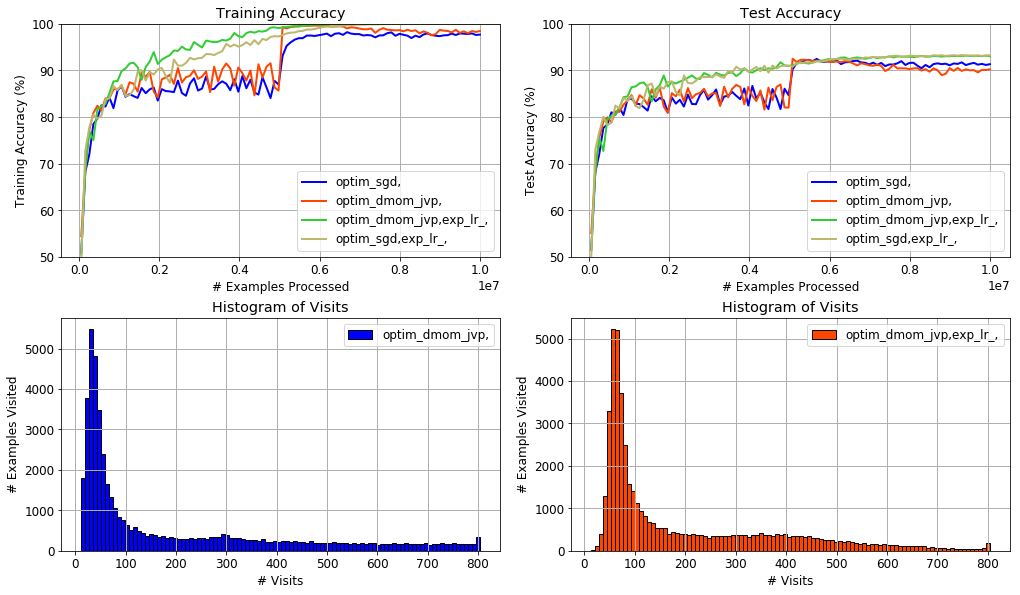

In [67]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*exp_lr.*batch_size_32.*maxw_1$|.*cifar10_linrank_explr/.*sgd.*epochs_200.*exp_lr.*batch_size_32.*|.*cifar10_linrank/.*epochs_200.*batch_size_32.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_bs_32.png'
lg_tags = ['optim_', 'exp_lr']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* 3 exp lr decay works better than multistep except for bs=1024 on cifar10

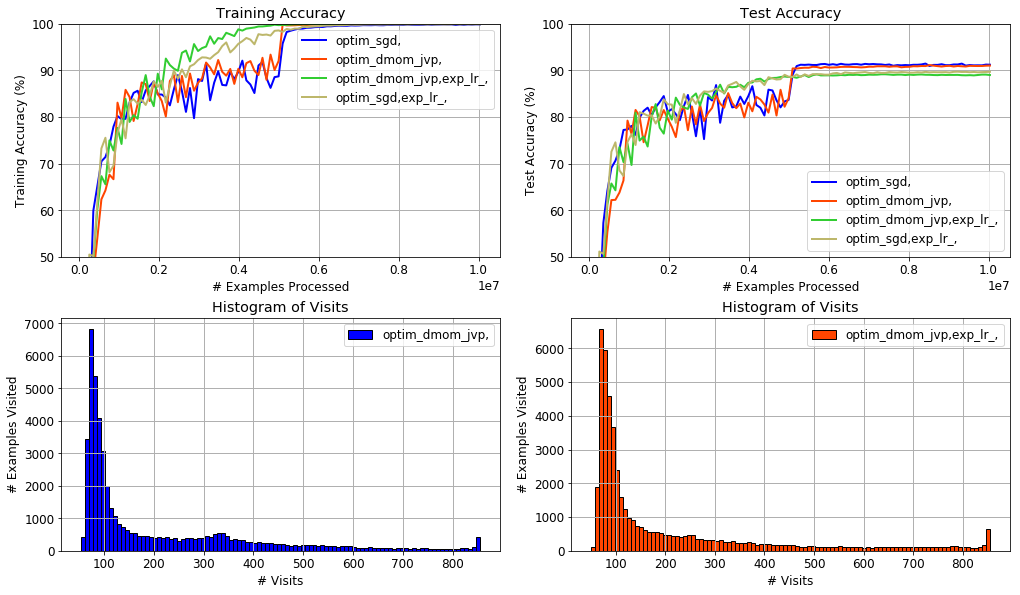

In [68]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*epochs_200.*exp_lr.*batch_size_1024.*maxw_1$|.*cifar10_linrank_explr/.*sgd.*epochs_200.*exp_lr.*batch_size_1024.*|.*cifar10_linrank/.*epochs_200.*batch_size_1024.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_bs_1024.png'
lg_tags = ['optim_', 'exp_lr']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* maxw=10 is bad, it adds fluctuations
* maxw=5 looks good but not substantially better. I'll go with maxw=1 for now until I do more cross-validation

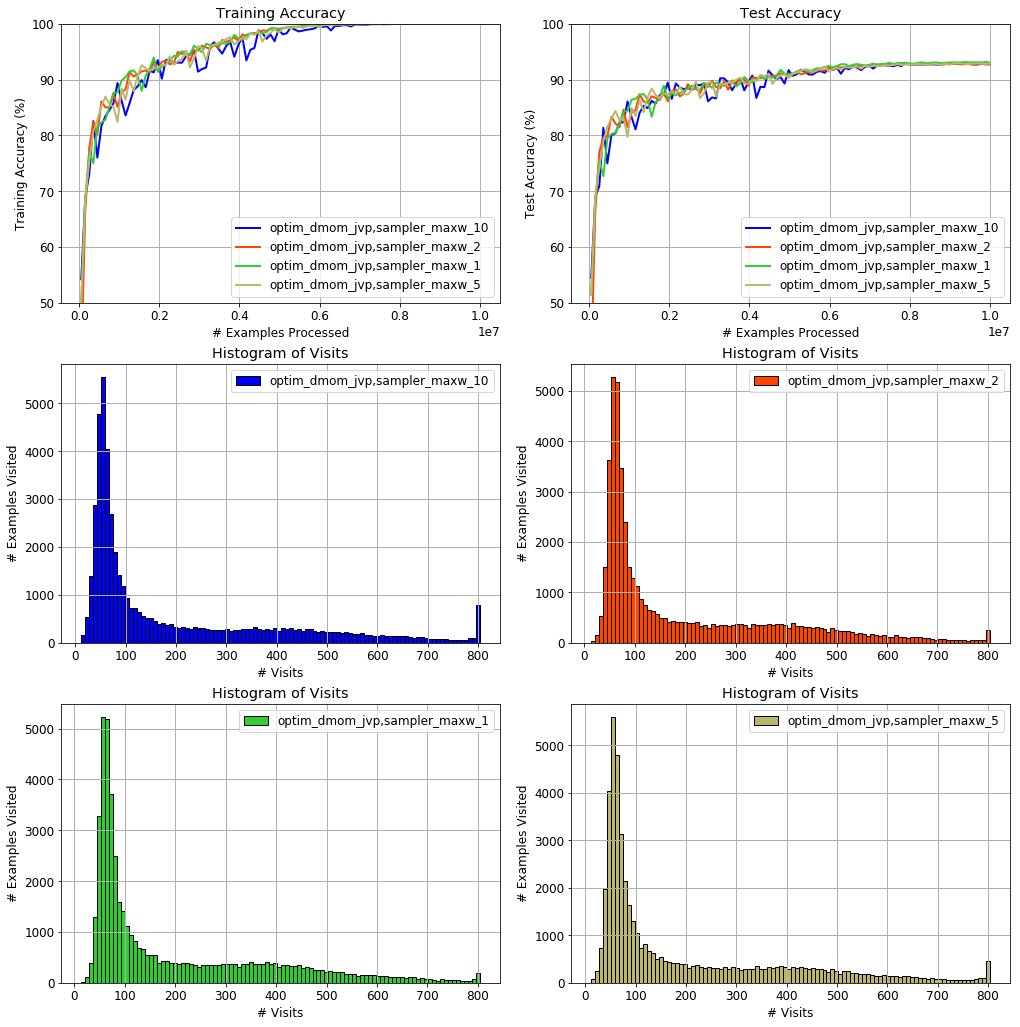

In [101]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*exp_lr.*batch_size_32.*maxw_.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_bs32_maxw.png'
lg_tags = ['optim_', 'sampler_maxw_']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

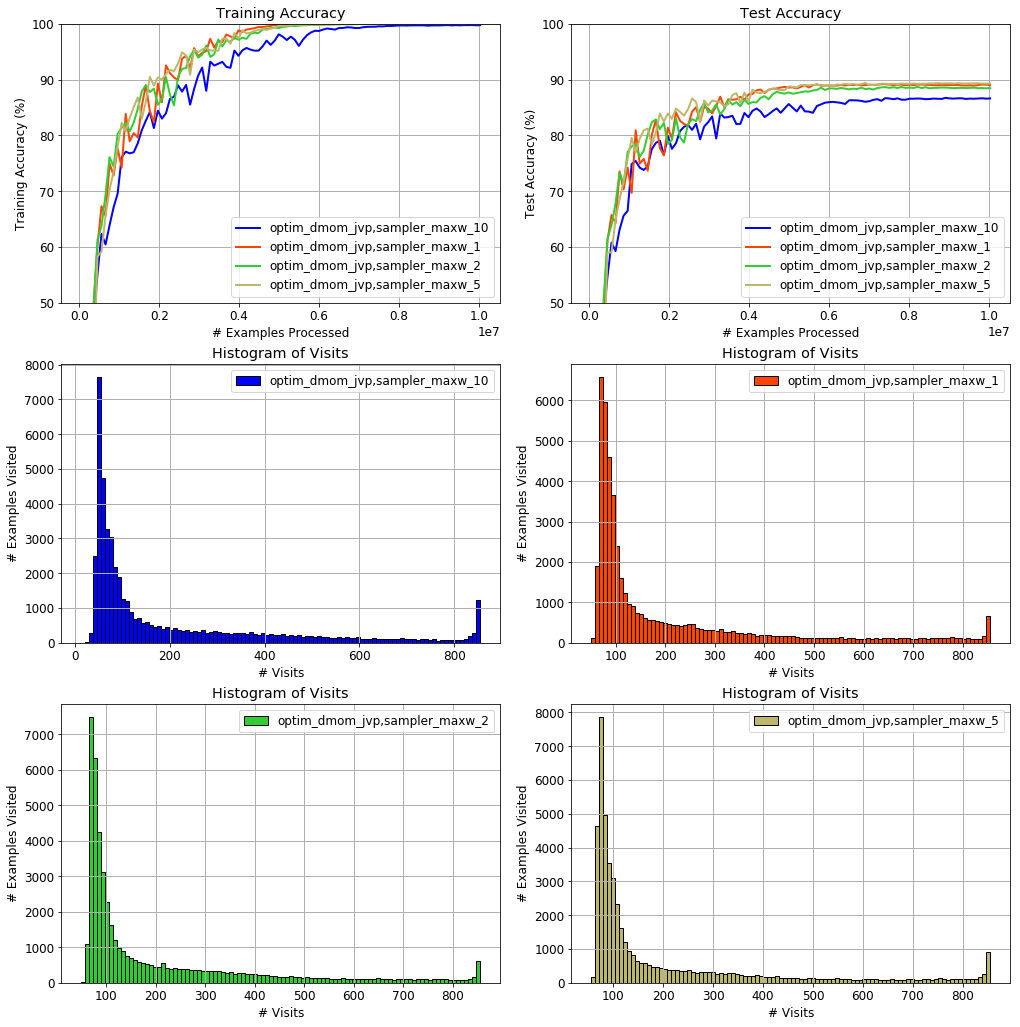

In [102]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*exp_lr.*batch_size_1024.*maxw_.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_bs1024_maxw.png'
lg_tags = ['optim_', 'sampler_maxw_']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* 1024 train is good but generalization is bad for both ours and sgd

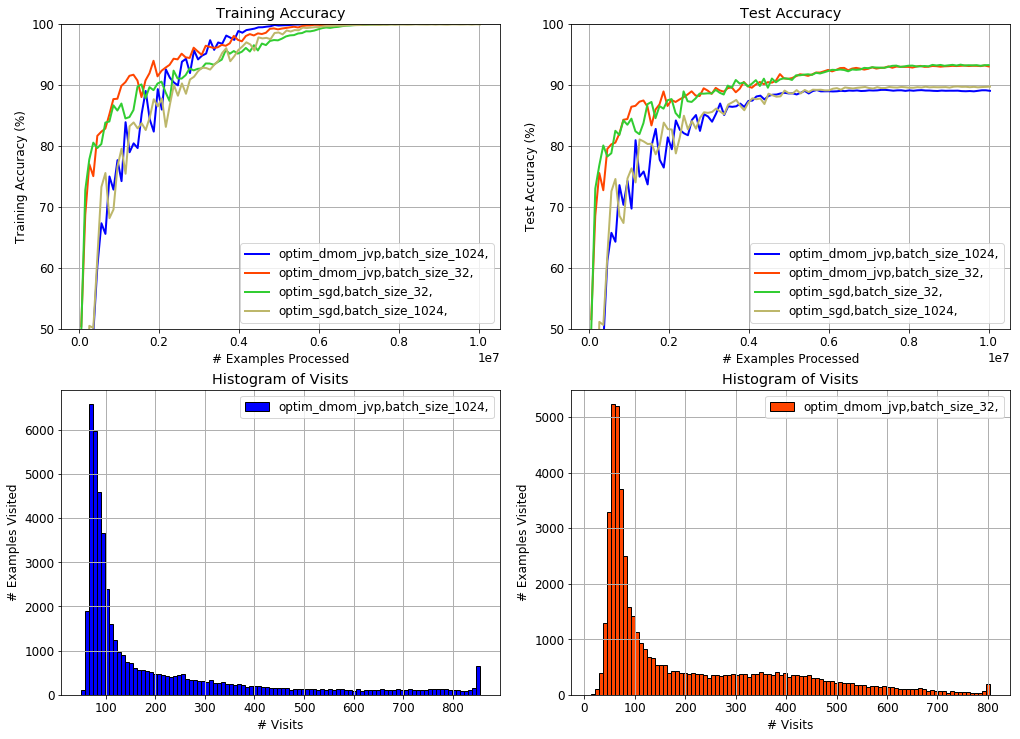

In [74]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*epochs_200.*exp_lr.*(log_nex_$|maxw_1$)']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_bs_32_vs_1024.png'
lg_tags = ['optim_', 'batch_size_']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* bs=32 half epochs is 1% below in generalization performance. bs=1024 2%

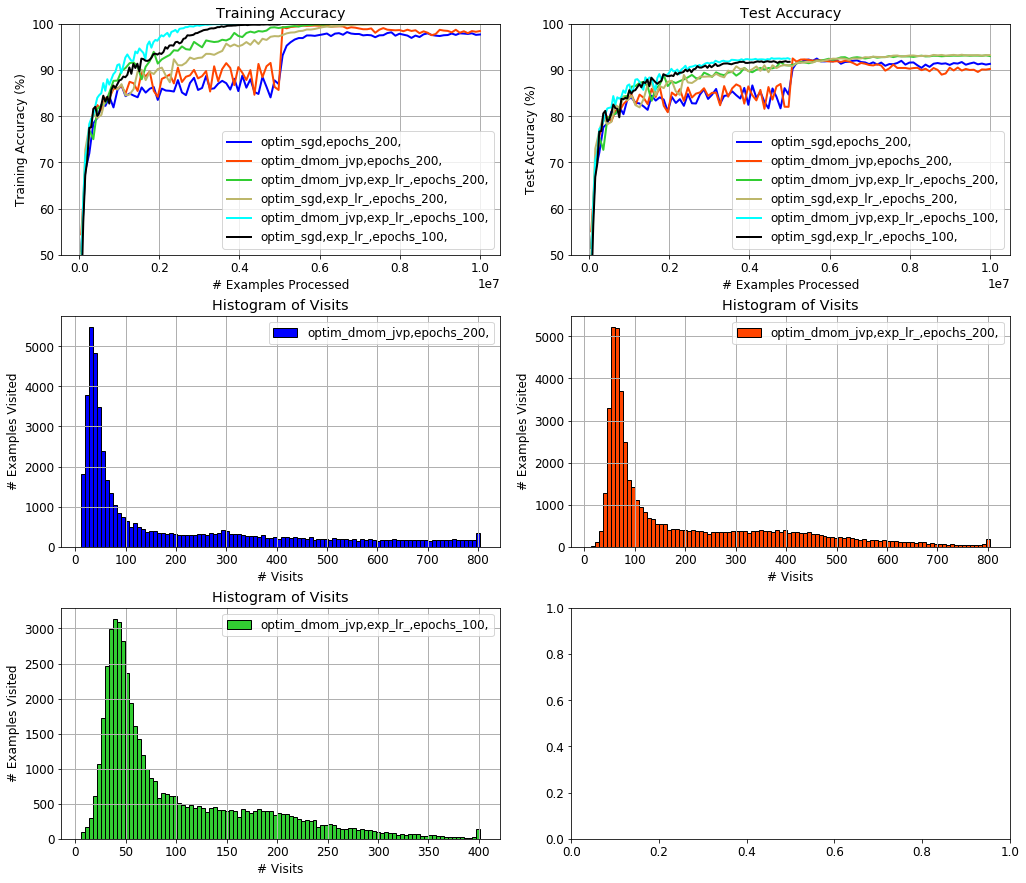

In [79]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*exp_lr.*batch_size_32.*(200$|maxw_1$)|.*cifar10_linrank_explr/.*sgd.*exp_lr.*batch_size_32.*|.*cifar10_linrank/.*epochs_200.*batch_size_32.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_bs_32_epochs_100_vs_200.png'
lg_tags = ['optim_', 'exp_lr_', 'epochs_']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

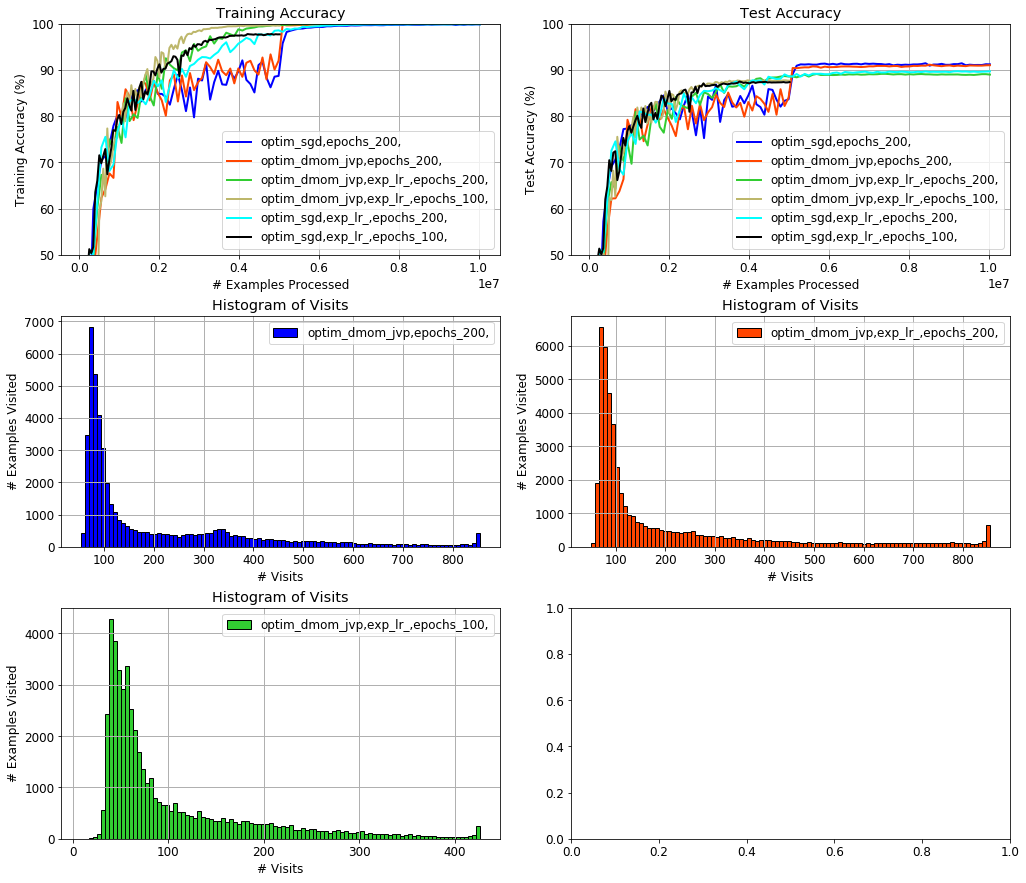

In [78]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*exp_lr.*batch_size_1024.*(200$|maxw_1$)|.*cifar10_linrank_explr/.*sgd.*exp_lr.*batch_size_1024.*|.*cifar10_linrank/.*epochs_200.*batch_size_1024.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_bs_1024_epochs_100_vs_200.png'
lg_tags = ['optim_', 'exp_lr_', 'epochs_']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

## svhn

* bs=128 in the end better train/test error if exp_lr, but sgd at the beginning found a better optima and lost it

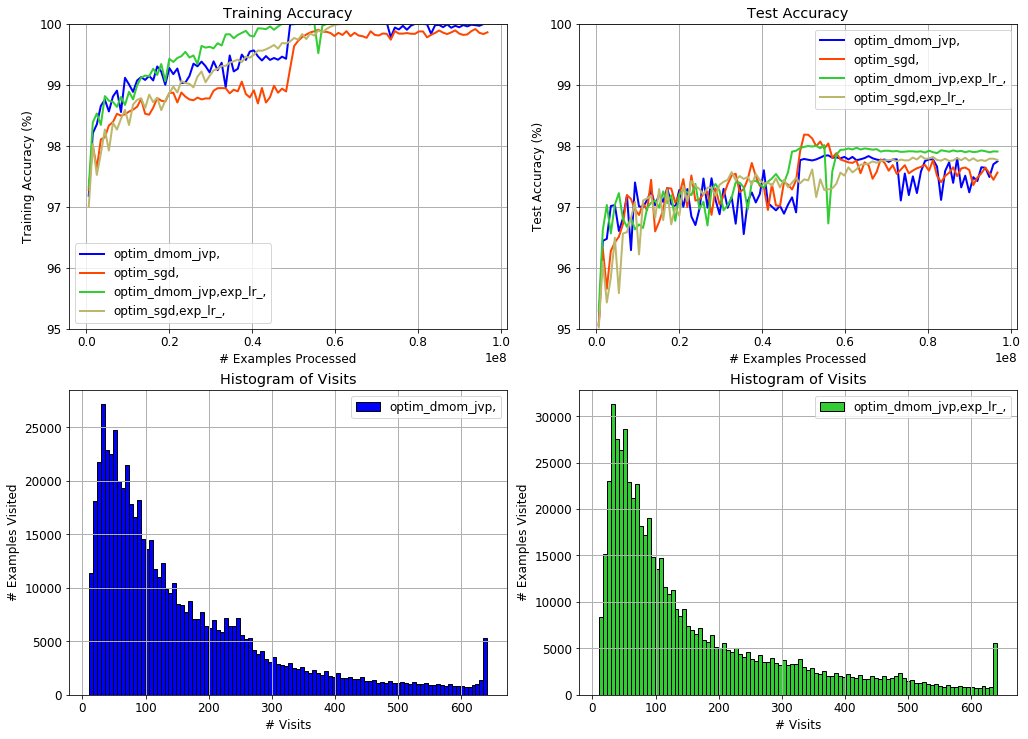

In [94]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank_explr/.*exp_lr.*batch_size_128.*maxw_1$|.*svhn_linrank_explr/.*sgd.*epochs_160.*exp_lr.*batch_size_128.*|.*svhn_linrank/.*epochs_160.*batch_size_128.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_explr_bs_128.png'
lg_tags = ['optim_', 'exp_lr']
ylim = [95, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* bs=1024, good train with explr, but overfits and can't get better than sgd

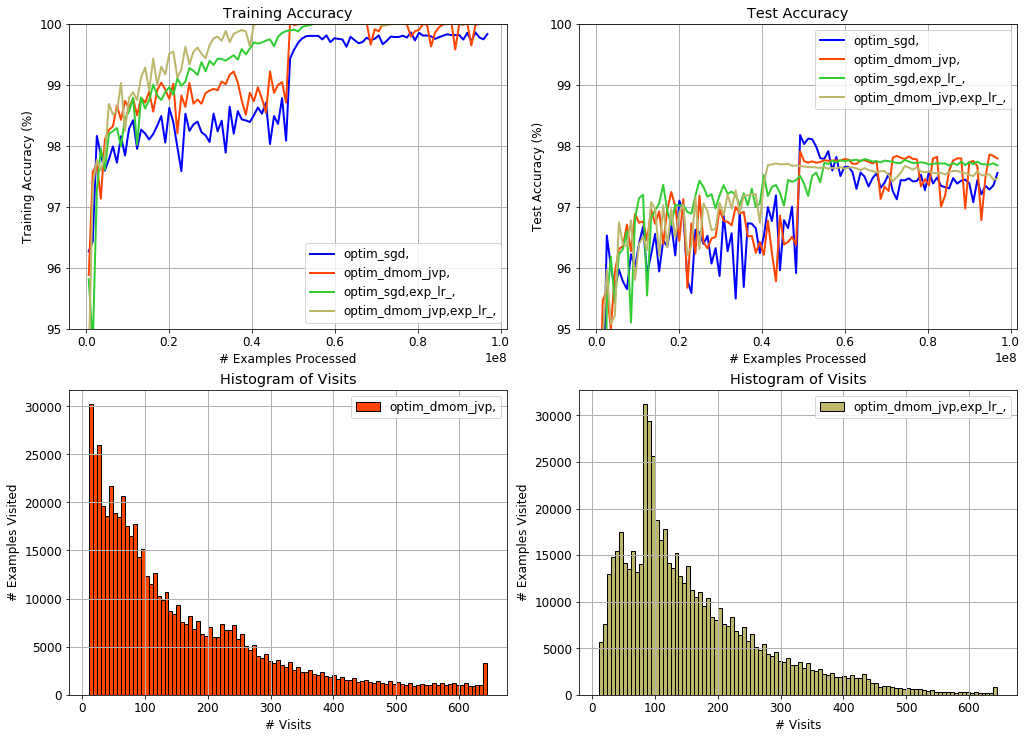

In [95]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank_explr/.*epochs_160.*exp_lr.*batch_size_1024.*maxw_1$|.*svhn_linrank_explr/.*sgd.*epochs_160.*exp_lr.*batch_size_1024.*|.*svhn_linrank/.*epochs_160.*batch_size_1024.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_explr_bs_1024.png'
lg_tags = ['optim_', 'exp_lr']
ylim = [95, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* train for 128 1024 of ours overlap, but test for 128 is better. again overfit in 1024

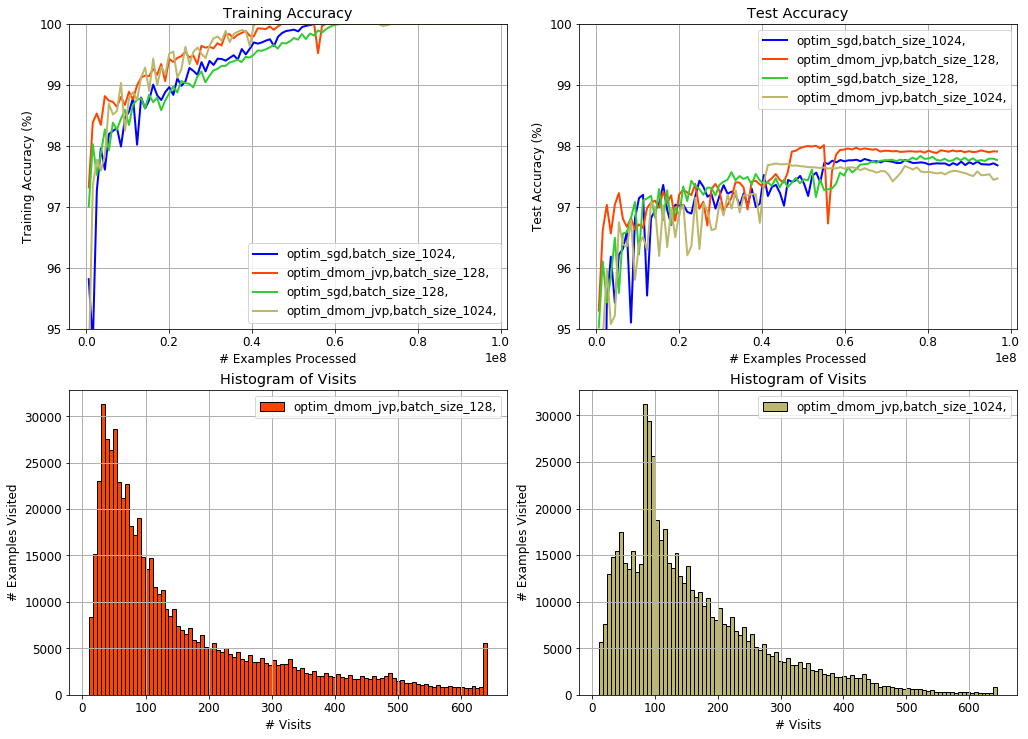

In [98]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank_explr/.*epochs_160.*exp_lr.*(log_nex_$|maxw_1$)']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_explr_bs_128_vs_1024.png'
lg_tags = ['optim_', 'batch_size_']
ylim = [95, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* maxw almost overlap, maxw=5 can drop sharply, maybe do grad clip

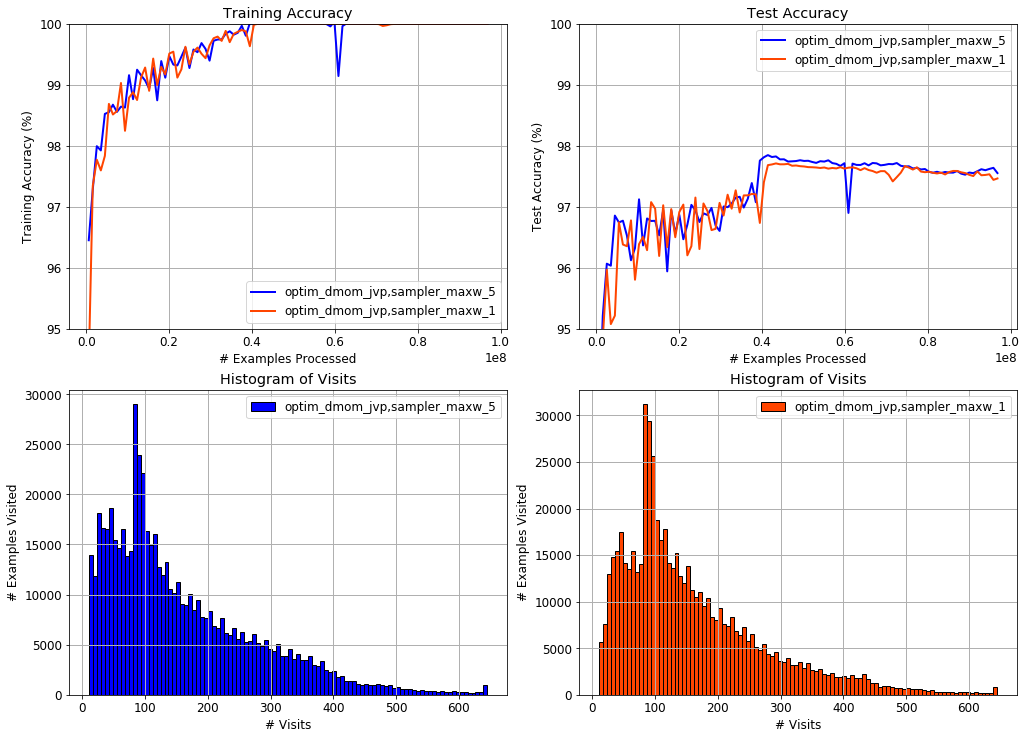

In [96]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank_explr/.*exp_lr.*batch_size_1024.*maxw_.*']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_maxw.png'
lg_tags = ['optim_', 'sampler_maxw_']
ylim = [95, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

## data augmentation

In [105]:
from torchvision import datasets, transforms

In [258]:
transform = [
    transforms.RandomAffine(10, (.1, .1), (0.7, 1.2), 10),
    transforms.ColorJitter(.2, .2, .2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    # normalize,
]
trainset = datasets.CIFAR10(root='../data/cifar10', train=True, transform=transforms.Compose(transform))

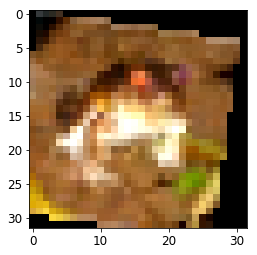

In [281]:
plt.imshow(trainset[0][0].numpy().transpose((1,2,0)))

In [301]:
transform = [
    transforms.RandomAffine(10, (.1, .1), (0.7, 1.), 10),
    transforms.ColorJitter(.2, .2, .2),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    # normalize,
]
trainset = datasets.SVHN(root='../data/svhn', split='train', transform=transforms.Compose(transform))

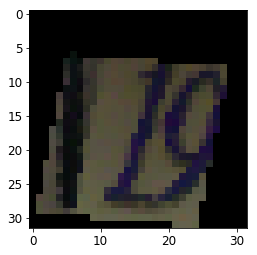

In [314]:
plt.imshow(trainset[0][0].numpy().transpose((1,2,0)))

* with data augmentation, ours still converges faster in training time but does not generalize well as well as sgd does. best is sgd with data augmentation. and with bs=32 ours would do even worse in test.

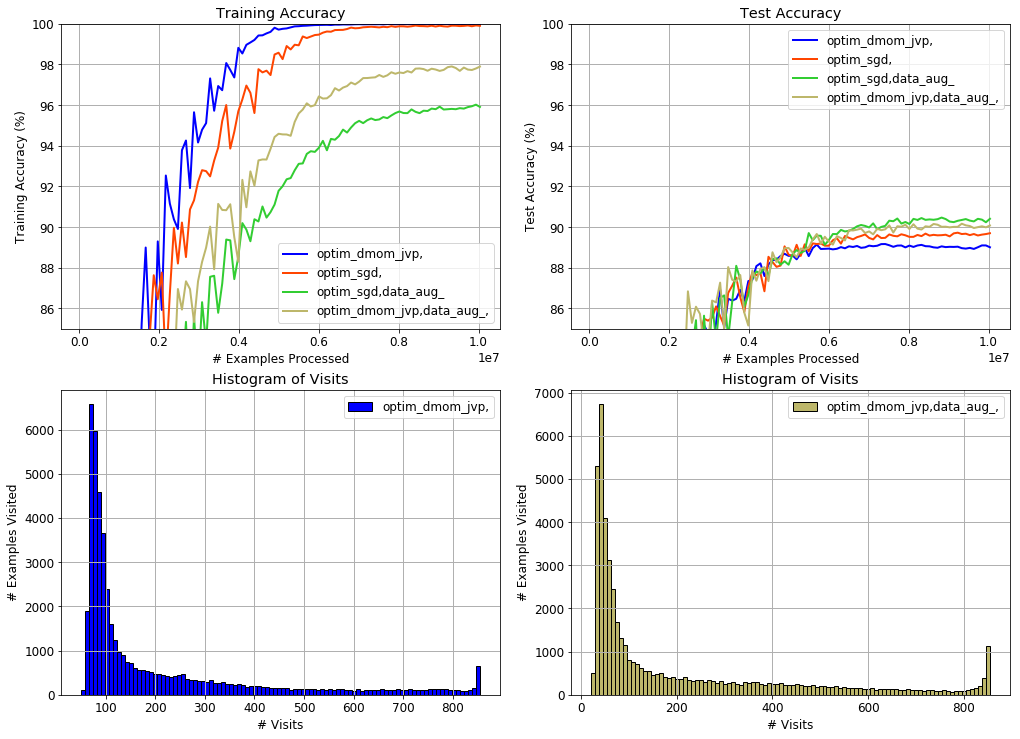

In [346]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*epochs_200.*exp_lr.*batch_size_1024.*(log_nex_$|maxw_1$)|.*cifar10_linrank_explr_daug/.*epochs_200.*exp_lr.*batch_size_1024']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_dataaug_bs1024.png'
lg_tags = ['optim_', 'data_aug_']
ylim = [85, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

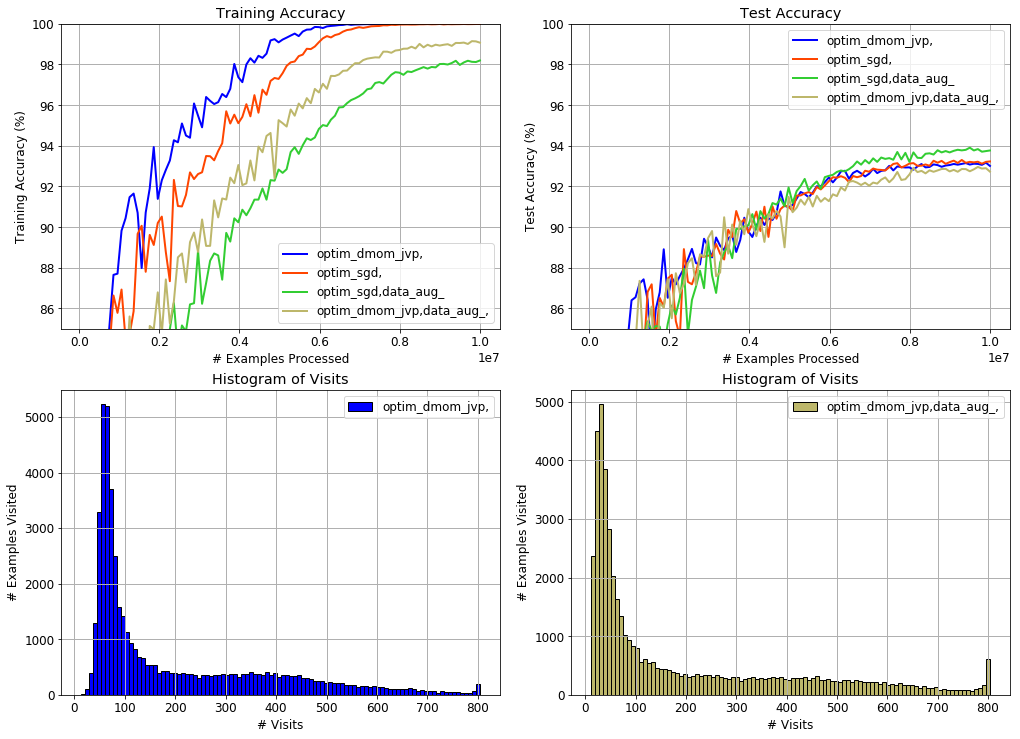

In [347]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*epochs_200.*exp_lr.*batch_size_32.*(log_nex_$|maxw_1$)|.*cifar10_linrank_explr_daug/.*epochs_200.*exp_lr.*batch_size_32']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_dataaug_bs32.png'
lg_tags = ['optim_', 'data_aug_']
ylim = [85, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

# weight noise

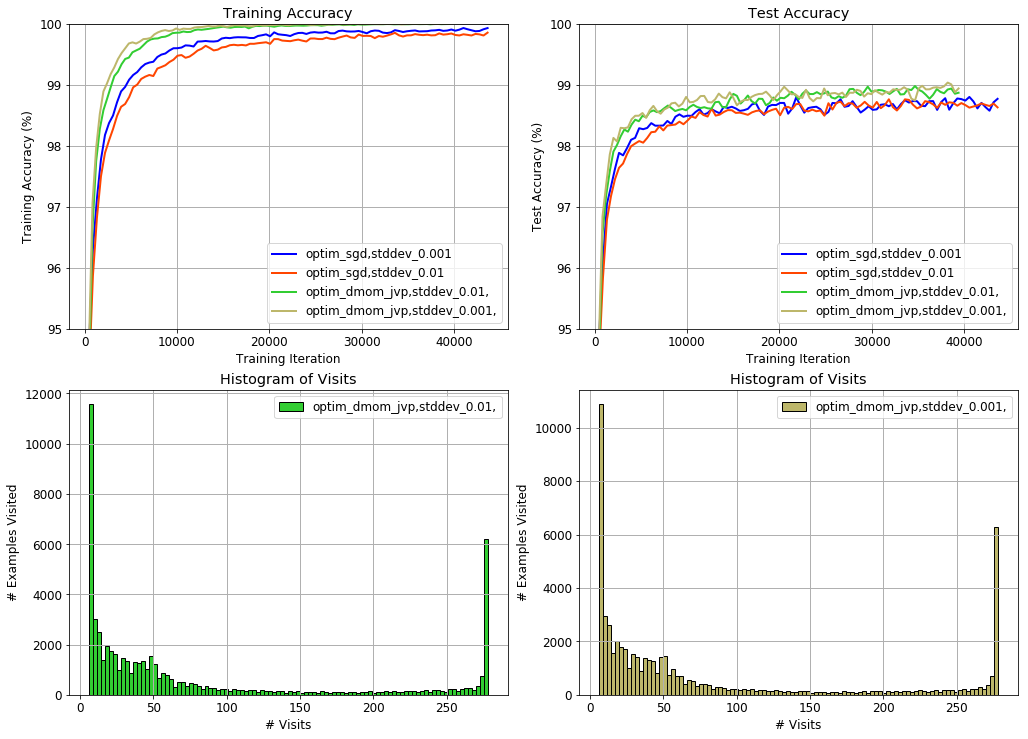

In [392]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*mnist_linrank_wnoise.*/.*wnoise_stddev.*']
tag_names = ['Tacc', 'Vacc', 'visits_h']
fig_name = 'figs_new/mnist_wnoise.png'
lg_tags = ['optim_', 'stddev_']
ylim = [95, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

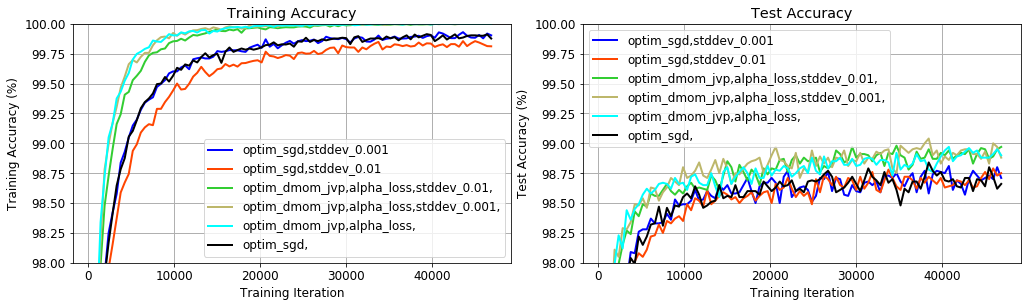

In [425]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*mnist_linrank_wnoise/.*|.*mnist_linrank/(?!.*alpha_one).*epochs_100,lr_decay_epoch_100.*']
tag_names = ['Tacc', 'Vacc']
fig_name = 'figs_new/mnist_wnoise.png'
lg_tags = ['optim_', 'alpha_', 'stddev_']
ylim = [98, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* helped us with generalization of bs=1024 to reach sgd bs=1024, but hurts us with bs=32

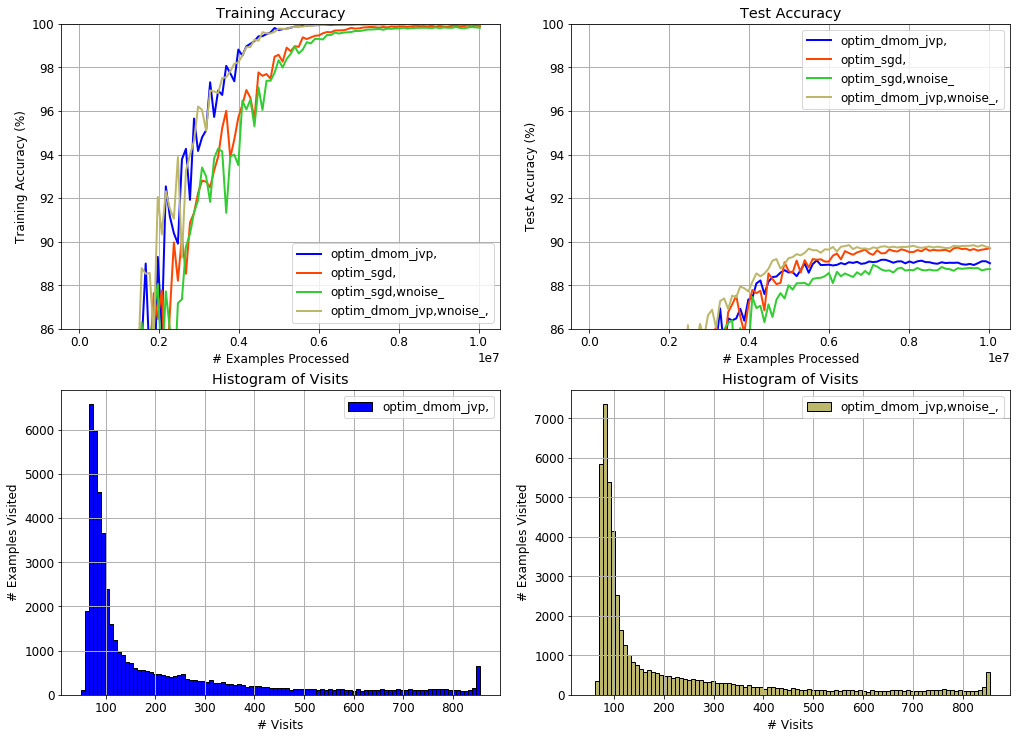

In [378]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*epochs_200.*exp_lr.*batch_size_1024.*(log_nex_$|maxw_1$)|.*cifar10_linrank_explr_wnoise/.*epochs_200.*exp_lr.*batch_size_1024']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_wnoise_bs1024.png'
lg_tags = ['optim_', 'data_aug_', 'wnoise_']
ylim = [86, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

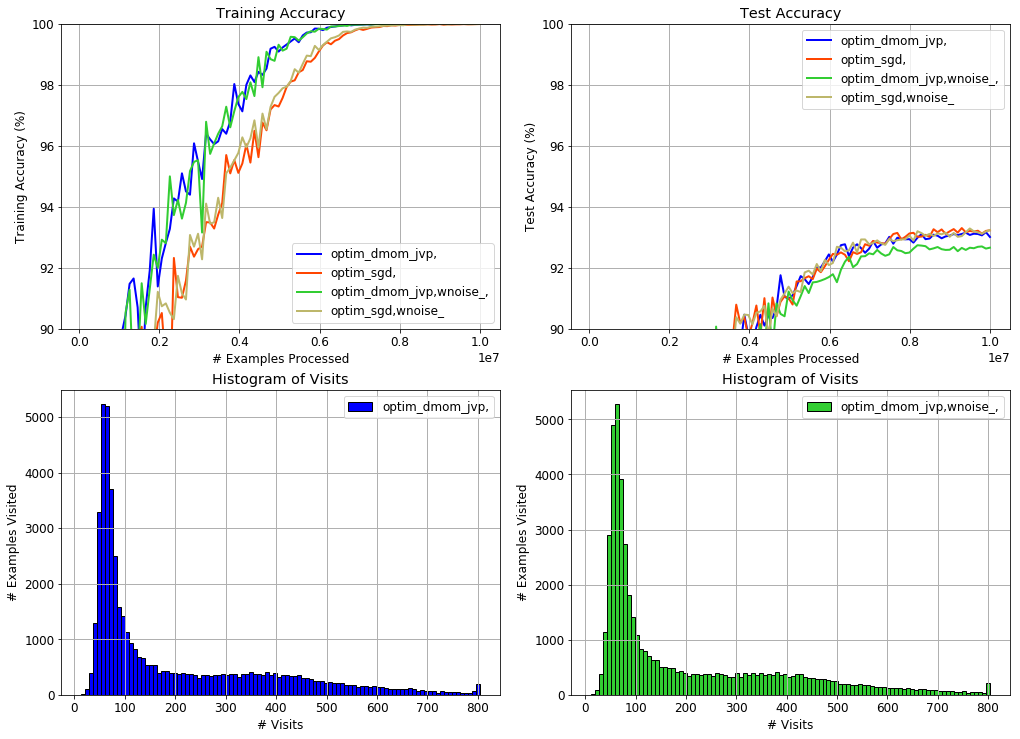

In [379]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*cifar10_linrank_explr/.*epochs_200.*exp_lr.*batch_size_32.*(log_nex_$|maxw_1$)|.*cifar10_linrank_explr_wnoise/.*epochs_200.*exp_lr.*batch_size_32']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/cifar10_linrank_explr_wnoise_bs32.png'
lg_tags = ['optim_', 'data_aug_', 'wnoise_']
ylim = [90, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

* on svhn, we still overfit, but at least we can reach sgd's performance in the middle

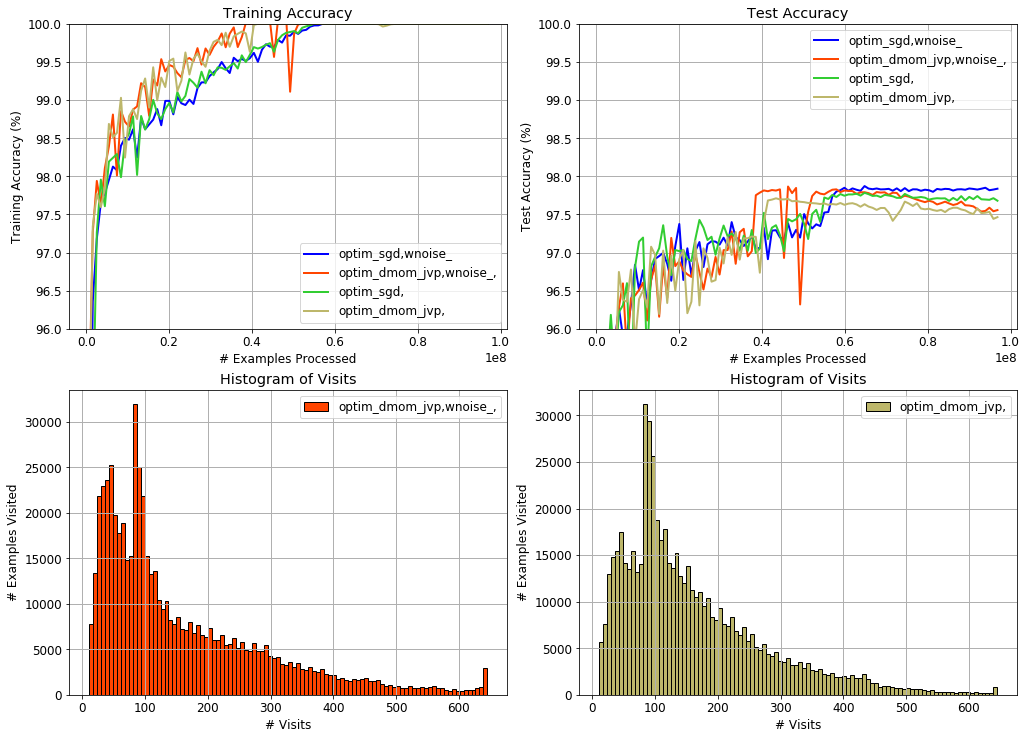

In [381]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank_explr/.*epochs_160.*exp_lr.*batch_size_1024.*(log_nex_$|maxw_1$)|.*svhn_linrank_explr_wnoise/.*epochs_160.*exp_lr.*batch_size_1024']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_explr_wnoise_bs1024.png'
lg_tags = ['optim_', 'wnoise_']
ylim = [96, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

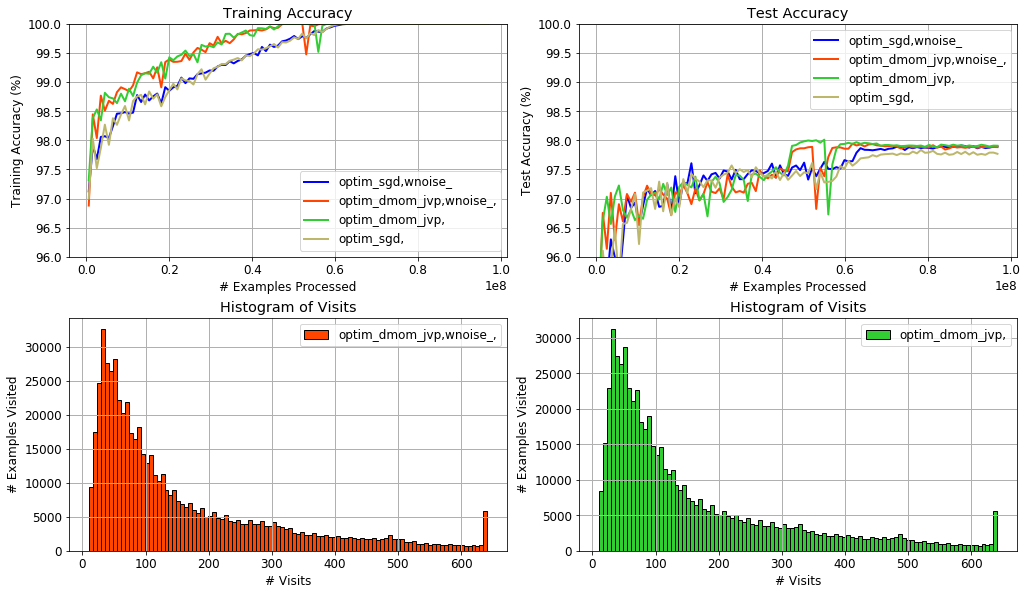

In [428]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*svhn_linrank_explr/.*epochs_160.*exp_lr.*batch_size_128.*(log_nex_$|maxw_1$)|.*svhn_linrank_explr_wnoise/.*epochs_160.*exp_lr.*batch_size_128']
tag_names = ['Tacc_Nex', 'Vacc_Nex', 'visits_h']
fig_name = 'figs_new/svhn_linrank_explr_wnoise_bs128.png'
lg_tags = ['optim_', 'wnoise_']
ylim = [96, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)

# Kfac

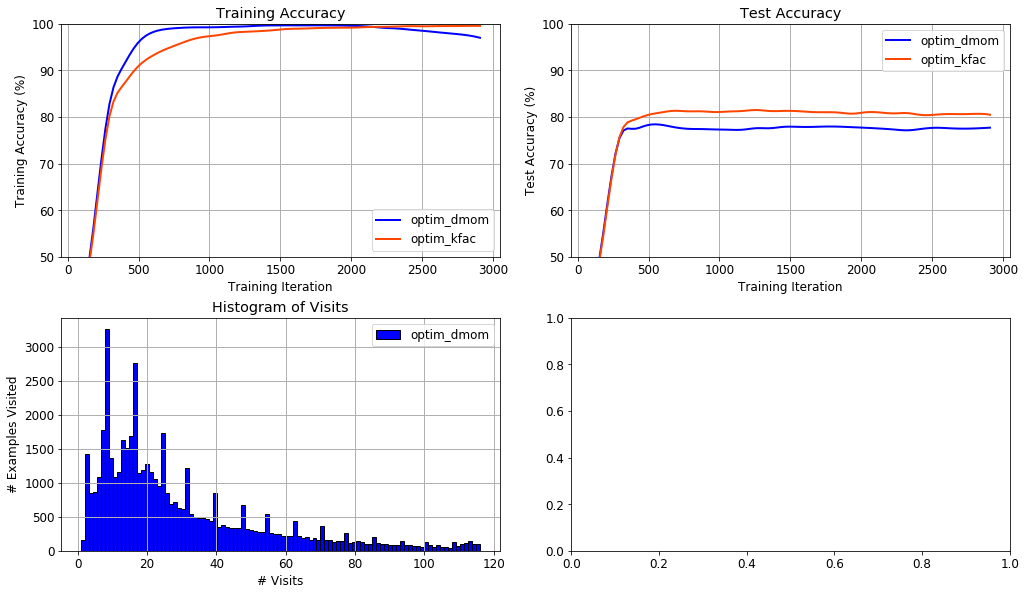

In [453]:
get_data_f = get_data_pth
# plot_f = plt.plot
plot_f = plot_smooth
logdir = '/u/faghri/dmom/code/runs/'
patterns = ['.*runs_cifar10_kfac/.*']
tag_names = ['Tacc', 'Vacc', 'visits_h']
fig_name = 'figs_new/cifar10_kfac.png'
lg_tags = ['optim_']
ylim = [50, 100]
data, run_names = plot_runs_and_tags(get_data_f, plot_f, logdir, patterns, tag_names, fig_name, lg_tags, ylim)